In [3]:
!pip install --user geopandas matplotlib fastparquet pyarrow

     ---------------------------------------- 0.0/51.1 kB ? eta -:--:--
     ---------------------------------------- 51.1/51.1 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/160.8 kB ? eta -:--:--
     -------------------------------------- 160.8/160.8 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 61.2/61.2 kB 3.4 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl.metadata (2.2 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------------------- -------------------- 0.5/1.1 MB 11.1 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 13.9 

In [16]:
import geopandas as gpd
import pandas as pd

filename = "taxi_zones.shp"

zones = gpd.read_file(filename)

<Axes: >

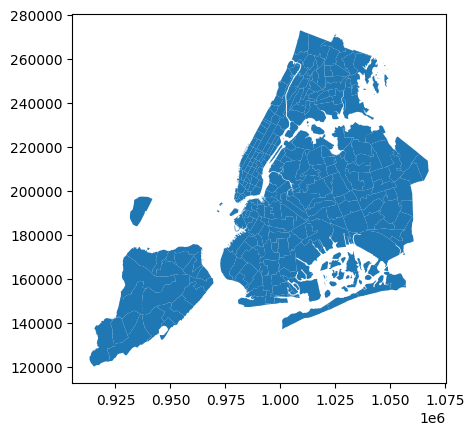

In [17]:
zones.plot()

In [26]:
from pathlib import Path

# Copy to your home directory the dataset using HDFS
# hdfs dfs -copyToLocal /user/s3263371/project/buildings
# buildings_dir = Path("/home/s3266443/dataset/buildings/")
buildings_dir = Path("buildings/")

files = [buildings_dir / "QN.csv", buildings_dir / "SI.csv", buildings_dir / "BK.csv", buildings_dir / "BX.csv", buildings_dir / "MN.csv"]

boroughs = []

for file in files:
    df = pd.read_csv(file, header=0, usecols=["ZoneDist1", "ComArea", "ResArea", "OfficeArea", "RetailArea", "FactryArea", "OtherArea", "XCoord", "YCoord"])
    boroughs.append(df)


df = pd.concat(boroughs, ignore_index=True)

df = df[df["XCoord"] != 0]
df = df[df["YCoord"] != 0]

buildings = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["XCoord"], df["YCoord"], crs="EPSG:2263"))

<Axes: >

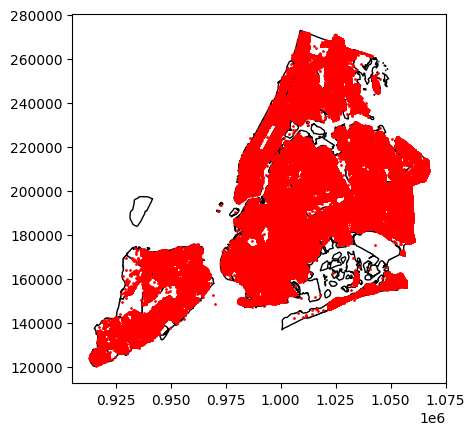

In [27]:
base = zones.plot(color="white", edgecolor="black")

buildings.plot(ax=base, marker="o", color="red", markersize=1)

In [48]:
def largest_zone(row):
    contained = buildings.within(row["geometry"])
    if not contained.any():
        return "Unknown"
    zone_areas = buildings[contained][["ComArea", "ResArea", "OfficeArea", "RetailArea", "FactryArea", "OtherArea"]].sum()
    #TODO maybe a weigthing per category, since floor area is not only an approximate measure the zoning of an area 
    zone = zone_areas.idxmax()
    return zone


zones["Zone"] = zones.apply(largest_zone, axis=1)
zones["LocationID"] = zones.index + 1

zones

,geometry,Zone,LocationID,Zone2
0,"POLYGON ((933100.918 192536.086, 933091.011 19...",Unknown,1,Unknown
1,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",ResArea,2,Park
2,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",ResArea,3,Residential
3,"POLYGON ((992073.467 203714.076, 992068.667 20...",ResArea,4,Residential
4,"POLYGON ((935843.310 144283.336, 936046.565 14...",ResArea,5,Residential
...,...,...,...,...
258,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",ResArea,259,Residential
259,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",ResArea,260,Residential
260,"POLYGON ((980555.204 196138.486, 980570.792 19...",OfficeArea,261,Commercial
261,"MULTIPOLYGON (((999804.795 224498.527, 999824....",ResArea,262,Residential


In [33]:
def determine_zone(row):
    if not isinstance(row["ZoneDist1"], str):
        return "Unkown"
    if row["ZoneDist1"][0] == "R":
        return "Residential"
    elif row["ZoneDist1"][0] == "C":
        return "Commercial"
    elif "/" in row["ZoneDist1"]:
        return "Mixed"
    elif row["ZoneDist1"][0] == "M":
        return "Manufacturing"
    elif row["ZoneDist1"] == "BPC":
        return "Residential"
    elif row["ZoneDist1"] in ["PARK", "PARKNYS", "PARKUS"]:
        return "Park"
    return "Unknown"

buildings["Zone"] = buildings.apply(determine_zone, axis=1)

In [7]:
buildings

,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,XCoord,YCoord,geometry,Zone
0,R10,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,Residential
1,R10,NaN,NaN,NaN,995513.0,209421.0,POINT (995513.000 209421.000),Residential
2,R10,NaN,NaN,NaN,995477.0,209867.0,POINT (995477.000 209867.000),Residential
3,R10,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,Residential
4,R10,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,Residential
...,...,...,...,...,...,...,...,...
858365,R7-2,NaN,NaN,NaN,1006751.0,256896.0,POINT (1006751.000 256896.000),Residential
858366,R7-2,NaN,NaN,NaN,1006821.0,257108.0,POINT (1006821.000 257108.000),Residential
858367,PARK,NaN,NaN,NaN,1006283.0,256853.0,POINT (1006283.000 256853.000),Park
858368,R7-2,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,Residential


In [30]:
def most_common_zone(row):
    contained = buildings.within(row["geometry"])
    if not contained.any():
        return "Unknown"
    zone = buildings[contained]["Zone"].aggregate(lambda x: pd.Series.mode(x)[0])
    return zone


zones["Zone2"] = zones.apply(most_common_zone, axis=1)
zones["LocationID"] = zones.index + 1

In [31]:
zones

,geometry,Zone,LocationID,Zone2
0,"POLYGON ((933100.918 192536.086, 933091.011 19...",Unknown,1,Unknown
1,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",ComArea,2,Park
2,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",ResArea,3,Residential
3,"POLYGON ((992073.467 203714.076, 992068.667 20...",ResArea,4,Residential
4,"POLYGON ((935843.310 144283.336, 936046.565 14...",ResArea,5,Residential
...,...,...,...,...
258,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",ResArea,259,Residential
259,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",ResArea,260,Residential
260,"POLYGON ((980555.204 196138.486, 980570.792 19...",ComArea,261,Commercial
261,"MULTIPOLYGON (((999804.795 224498.527, 999824....",ResArea,262,Residential


In [49]:
zones.loc[zones["LocationID"] == 1, "Zone"] = "Airport"
zones.loc[zones["LocationID"] == 132, "Zone"] = "Airport"
zones.loc[zones["LocationID"] == 138, "Zone"] = "Airport"
zones.loc[zones["LocationID"] == 199, "Zone"] = "Jail"

zones.loc[zones["Zone"] == "ComArea", "Zone"] = "Commercial"
zones.loc[zones["Zone"] == "ResArea", "Zone"] = "Residential"

zones.loc[zones["Zone2"] == "Park", "Zone"] = "Park"

<Axes: >

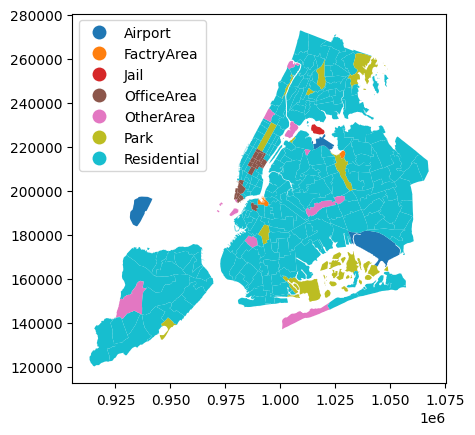

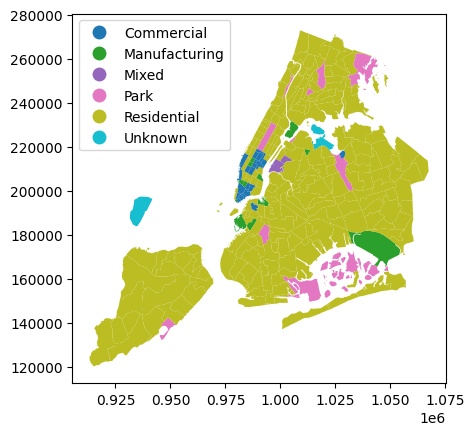

In [50]:
zones.plot(column="Zone", legend=True, legend_kwds={"loc": "upper left"})
zones.plot(column="Zone2", legend=True, legend_kwds={"loc": "upper left"})

In [10]:
zones_df = pd.DataFrame(zones[["LocationID", "Zone"]])
out_dir = Path("out/")
out_dir.mkdir(exist_ok=True)
zones_df.to_parquet(out_dir / "zoning.parquet", index=False)

In [11]:
test = pd.read_parquet(out_dir / "zoning.parquet")
test

,LocationID,Zone
0,1,Unknown
1,2,Park
2,3,Residential
3,4,Residential
4,5,Residential
...,...,...
258,259,Residential
259,260,Residential
260,261,Commercial
261,262,Residential
